In [216]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob, Blobber
# from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn

nltk.download('vader_lexicon', download_dir='.')


[nltk_data] Downloading package vader_lexicon to ....
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Загрузка и первоначальное знакомство с данными

In [217]:
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

DATA_DIR = '/kaggle/input/sf-booking/'
hotels_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
hotels_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')'''

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\nDATA_DIR = '/kaggle/input/sf-booking/'\nhotels_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')\nhotels_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')\nsample_submission = pd.read_csv(DATA_DIR + 'submission.csv')"

In [218]:
hotels_train=pd.read_csv('data\hotels_train.csv')
hotels_test=pd.read_csv('data\hotels_test.csv')
hotels_train['type']='train'
hotels_test['type']='test'

In [219]:
X=pd.concat([hotels_train, hotels_test], axis=0)
X.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,type
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,train
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,train
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,train
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,train
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,train


In [220]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [221]:
X[X['lat'].isnull()]['hotel_name'].nunique() #Кол-во отелей с неизвестными координатами

17

In [222]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
y = X[X['type']=='train']['reviewer_score'] 
X = X.drop(['reviewer_score'], axis = 1)  

In [223]:
X['hotel_name'].nunique() #кол-во уникальных отелей

1492

### Извлечем дополнительные параметры из признака адреса отеля

In [224]:
X['country']=X['hotel_address'].apply(lambda x: x.split(' ')[-1]) #получаем страну, в которой расположен отель


In [225]:
X['country'].value_counts() #перечень стран в датасете

Kingdom        262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: country, dtype: int64

In [226]:
X['country']=X['country'].replace('Kingdom', 'United Kingdom')

In [227]:
X['city']=X['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-2]!='United' else x.split(' ')[-5])#получаем признак города

In [228]:
X['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Кол-во городов соответствует кол-ву стран, один из признаков является избыточным, но перед тем как избавиться от одного из признаков,  выведем перечень главных достопримечательностей в рамках города (эйфелева башня, биг-бэн и т.д), чтобы в дальнешем рассчитать расстояние до отеля

In [229]:
popular_place={'London':(51.50548600,-0.07545900), 'Barcelona': (41.40355600,2.17393900), 'Paris':(48.85805600,2.29444400),'Amsterdam': (52.37348400,4.89806200),
'Vienna':(48.20833300,16.37277800) ,'Milan': (45.46473600,9.18873000)
}

In [230]:
X['popular_place']=X['city'].apply(lambda x: popular_place[x])

In [231]:
list_hotel=pd.DataFrame(X.groupby(['hotel_name','popular_place','lat','lng'])['average_score'].count()).reset_index()

from geopy.distance import geodesic
def distance(x):
    ''' Расчет дистанции от отеля до основной достопримечательности'''
    try:
        geodesic((x['lat'],x['lng']), x['popular_place']).kilometers
    except ValueError:
        return 0
    else:
        dist=geodesic((x['lat'],x['lng']), x['popular_place']).kilometers
        return dist

list_hotel['distance']=list_hotel.apply(distance, axis=1)

In [232]:
X=X.merge(list_hotel, left_on=['hotel_name','lat','lng'], right_on=['hotel_name','lat','lng'], how='left') #обогащаем нашу модель новым параметром- расстояние до достопримечательности

In [233]:
X=X.drop(columns=['city','popular_place_x','popular_place_y','average_score_y'])

### Национальность пользователя

In [234]:
X['reviewer_nationality']=X['reviewer_nationality'].apply(lambda x: x[1:len(x)-1]) #очистка наименований от лишних пробелов

In [235]:
X['local']=X.apply(lambda x: 1 if x['country']==x['reviewer_nationality'] else 0, axis=1) #добавим признак местного жителя

In [236]:
X['local'].value_counts()

0    337335
1    178403
Name: local, dtype: int64

In [237]:
X['new_reviewer']=X['total_number_of_reviews_reviewer_has_given'].apply(lambda x: 1 if x==1 else 0) #добавим признак нового пользователя сервиса

Избавимся от признака "национальность", заменив данный признак на континент, к которому относится та или иная страна

In [238]:
top_country_reviewer_nationality=list(X['reviewer_nationality'].value_counts().index)

In [239]:
nationality=pd.DataFrame(top_country_reviewer_nationality).rename(columns={0:'reviewer_nationality'})

In [240]:
import pycountry_convert as pc

def country_to_continent(country_name):
    '''выводим континент по указанной стране путешественника'''
    try:
        pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
    except KeyError:
        country_continent_code='Other'
    else:
        try:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
            pc.country_alpha2_to_continent_code(country_alpha2)
        except KeyError:
            country_continent_code='Other'
        else:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
            country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    return country_continent_code


nationality['continent']=nationality['reviewer_nationality'].apply(country_to_continent)


In [241]:
X=X.merge(nationality, left_on='reviewer_nationality', right_on='reviewer_nationality', how='left')

### Работа с датой

In [242]:
X['days_since_review']=X['days_since_review'].apply(lambda x: x.replace(' days','')) 
X['days_since_review']=X['days_since_review'].apply(lambda x: int(x.replace(' day','')))#приводим значение кол-ва дней к числовому типу

In [243]:
X['season']=pd.to_datetime(X['review_date']).dt.month #выводим месяц, когда был оставлен отзыв

In [244]:
X['season'].value_counts() # смотрим на месяца с максимальной активностью пользователей

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: season, dtype: int64

In [245]:
X['season']=X['season'].apply(lambda x: 1 if x in [8,7,5] else 0) # добавляем признак высокого сезона 

### Работа с тегами

In [246]:
def tags(tag)->list:
    '''преобразование перечня тегов к удобному в работе списку '''
    list_tag=list(tag.replace('[','').replace(']','').split("',"))
    list_of_tags=[]
    for i in list_tag:
        i=i.replace("'",'')
        new_tag=' '.join(i.split())
        new_tag=new_tag.lower()
        list_of_tags.append(new_tag)
    return list_of_tags

X['tags']=X['tags'].apply(tags)


In [247]:
res = [j for i in list(X['tags']) for j in i]
res=pd.DataFrame(res)

In [248]:
top_tags=list(res[0].value_counts().index)

In [249]:
tags=pd.DataFrame(top_tags).rename(columns={0:'tag'}) #перечень всех тегов

Обогащаем нашу модель за счет анализа тегов. Добавим такие признак, как: наличие wifi, завтрака, вида из окна, парковки и т.д.

In [250]:
tags['leiser_trip']=tags['tag'].apply(lambda x: 1 if x=='leisure trip' else 0) 
tags['business_trip']=tags['tag'].apply(lambda x: 1 if x=='business trip' else 0) 
tags['breakfast']=tags['tag'].apply(lambda x: 1 if 'breakfast' in x else 0) #есть завтраки
tags['wifi']=tags['tag'].apply(lambda x: 1 if 'wifi' in x or 'wi fi' in x or 'internet' in x else 0) 
tags['view']=tags['tag'].apply(lambda x: 1 if 'view' in x else 0) #хороший вид
tags['parking']=tags['tag'].apply(lambda x: 1 if 'parking' in x else 0)
tags['no_window']=tags['tag'].apply(lambda x: 1 if 'without window' in x  or 'no window' in x else 0)
tags['economy']=tags['tag'].apply(lambda x: 1 if 'economy' in x  else 0)
tags['pet']=tags['tag'].apply(lambda x: 1 if 'with a pet' in x  else 0)
tags['spa']=tags['tag'].apply(lambda x: 1 if 'spa' in x else 0)

In [251]:
def night(tag):
    '''выводим кол-во ночей, проведенных путешествнником в отеле'''
    tag_count_nights=1
    if re.fullmatch(r'stayed\s\d+\snight\w?', tag):
        tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', tag)][0]

    return tag_count_nights

tags['night']=tags['tag'].apply(night)

In [252]:
reviewer_types = {
        'solo traveler': 1,
        'couple': 2,
        'travelers with friends': 3,
        'family with young children': 4,
        'family with older children': 5,
        'group': 6
        }
    

tags['reviewer_types']=tags['tag'].apply(lambda x: reviewer_types.get(x,0))

In [253]:
def premium(tag):
    '''признак улучшенного номера'''
    premium=['queen', 'king', 'suite', 'deluxe', 'club', 'premium']
    for i in premium:
        if i in tag:
            return 1
            break
    return 0

tags['premium']=tags['tag'].apply(premium)

In [254]:
def type_room(tag):
    '''определяем тип номера'''
    type_apprtament= {
        'apartment': 4,
        'studio': 3,
        'room': 2,
        'guestroom': 1
        }

    list_type=['apartment', 'studio','guestroom', 'room']

    for i in list_type:
        if i in tag:
            return type_apprtament[i]
            break
    return 0


tags['type_room']=tags['tag'].apply(type_room)

In [255]:
type_tags=list(tags.columns)[1:]

In [256]:
dict_tags={} #создаем словарь с тэгами для ускорения получения финального значения типа

for i in type_tags:
    new={}
    for tag, type in zip(tags['tag'].values, tags[i].values) :
        new.setdefault(tag,type)
    dict_tags.setdefault(i,new)

In [257]:
def value_of_type(tag_list, type):
   '''функция возвращает финальное значение для отобранных видов тегов'''
   global dict_tags
   max_value=0
   for tag in tag_list:
      value_tag=dict_tags[type][tag]
      if value_tag>max_value:
         max_value=value_tag
   return max_value


for i in type_tags:
   X[i]=X['tags'].apply(lambda x: value_of_type(x, i))

### Оценка эмоциональной окраски отзыва

В работах других участников увидела интересную проработку отзывов со стороны эмоционального окраса. В своей работе также решила примениь данный метод

In [258]:
# Создаём объекты SentimentIntensityAnalyzer
positive = SentimentIntensityAnalyzer()
negative = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(negative.polarity_scores(example), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative.lexicon.update(negative_words)
positive.lexicon.update(positive_words)

print(f' - после преобразований (для негативного контекста):')
print(negative.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(positive.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(negative.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(negative.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
X['negative_review_temp'] = X['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
X['positive_review_temp'] = X['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
X['positive_review_temp'] = X['negative_review'].apply(lambda x: x.replace('All good', 'Positive'))
X['positive_review_temp'] = X['negative_review'].apply(lambda x: x.replace('No complaints', 'Positive'))
X['positive_review_temp'] = X['negative_review'].apply(lambda x: x.replace('Nothing to dislike', 'Positive'))
X['positive_review_temp'] = X['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))


Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [259]:
%%time

X['negative_review_sentiments'] = X['negative_review_temp'].apply(lambda x: negative.polarity_scores(x))

X['positive_review_sentiments'] = X['positive_review_temp'].apply(lambda x: positive.polarity_scores(x))

# формируем новые признаки:
X['neg_review_sentiments_neg'] = X['negative_review_sentiments'].apply(lambda x: x['neg'])
X['neg_review_sentiments_neu'] = X['negative_review_sentiments'].apply(lambda x: x['neu'])
X['neg_review_sentiments_pos'] = X['negative_review_sentiments'].apply(lambda x: x['pos'])
X['neg_review_sentiments_compound'] = X['negative_review_sentiments'].apply(lambda x: x['compound'])

X['pos_review_sentiments_neg'] = X['positive_review_sentiments'].apply(lambda x: x['neg'])
X['pos_review_sentiments_neu'] = X['positive_review_sentiments'].apply(lambda x: x['neu'])
X['pos_review_sentiments_pos'] = X['positive_review_sentiments'].apply(lambda x: x['pos'])
X['pos_review_sentiments_compound'] = X['positive_review_sentiments'].apply(lambda x: x['compound'])


CPU times: total: 3min 20s
Wall time: 3min 20s


In [260]:
X=X.drop(columns=['tags','lat', 'lng','hotel_address', 'review_date', 'negative_review', 'positive_review',  'negative_review_temp', 'positive_review_temp',
       'negative_review_sentiments', 'positive_review_sentiments' ])

### Проведем кодирование необходимых нам признаков

In [261]:
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

ord_encoder = ce.OneHotEncoder()
data_bin = ord_encoder.fit_transform(X[['country', 'continent']])
X = pd.concat([X, data_bin], axis=1)


In [262]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(X[['hotel_name']])
#X = pd.concat([X, type_bin], axis=1) # в дальнейшем отказалась от данного признака, т.к. по итогу расчета показатель информативности опказался минимальным

In [263]:
X=X.drop(columns=['reviewer_nationality', 'hotel_name', 'country', 'continent'])

### Нормализуем признаки

In [264]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(X[['days_since_review']])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm).rename(columns={0:'days_since_review_normalize'})
X = pd.concat([X, df_mm], axis=1)

In [265]:
X=X.drop(columns=['days_since_review'])

In [266]:
X['distance']=X['distance'].fillna(0)

### оценка значимости непрерывных переменных

Для оценки значимости непрерывных переменных воспользуемся ANNOVA, а для категориальных - X^2

In [267]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score_x', 'review_total_negative_word_counts', 'total_number_of_reviews', 
              'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'distance', 'neg_review_sentiments_neg',
              'neg_review_sentiments_neu', 'neg_review_sentiments_pos', 'neg_review_sentiments_compound', 'pos_review_sentiments_neg',
              'pos_review_sentiments_neu', 'pos_review_sentiments_pos', 'pos_review_sentiments_compound', 'days_since_review_normalize']

# категориальные признаки
cat_cols = ['local', 'new_reviewer', 'season', 'leiser_trip', 'business_trip', 'breakfast', 'wifi', 'view', 
              'parking', 'no_window', 'economy', 'pet', 'spa', 'night', 'reviewer_types', 'premium', 
              'type_room', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 
              'continent_1', 'continent_2', 'continent_3', 'continent_4', 'continent_5', 'continent_6', 'continent_7']

<AxesSubplot: >

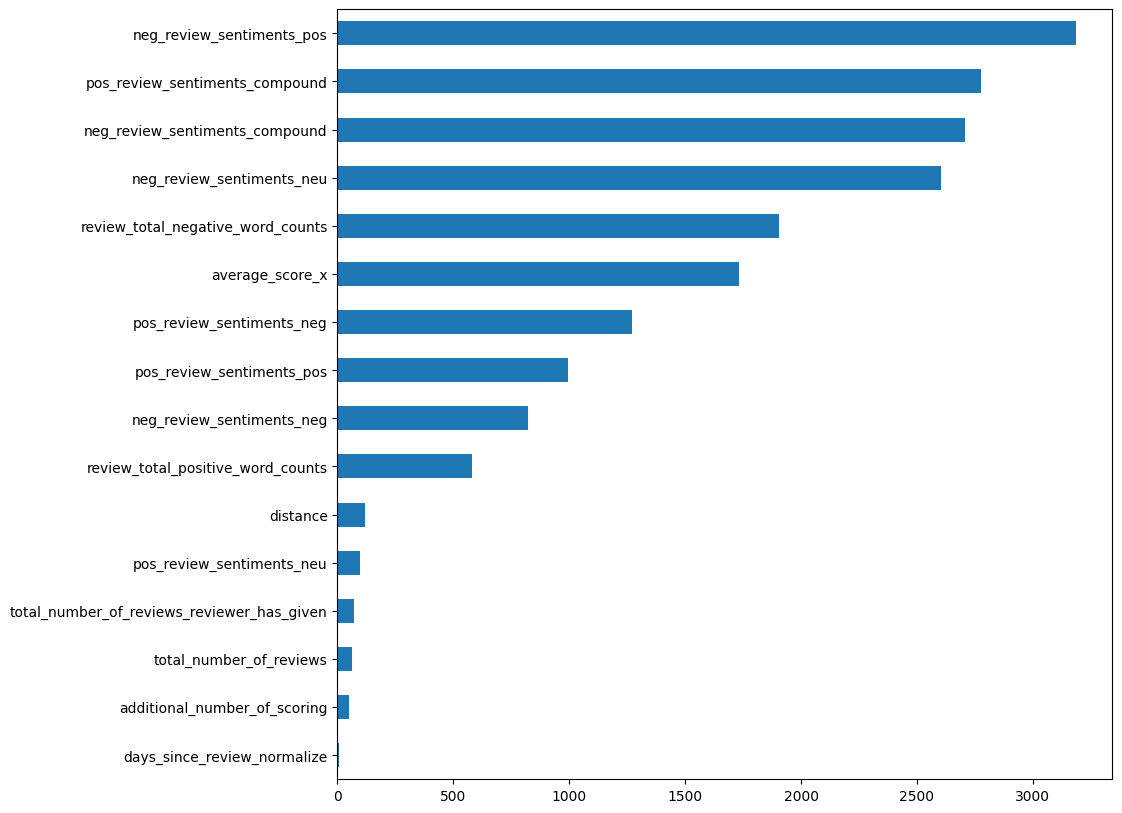

In [268]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[X['type']=='train'][num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='')

<AxesSubplot: >

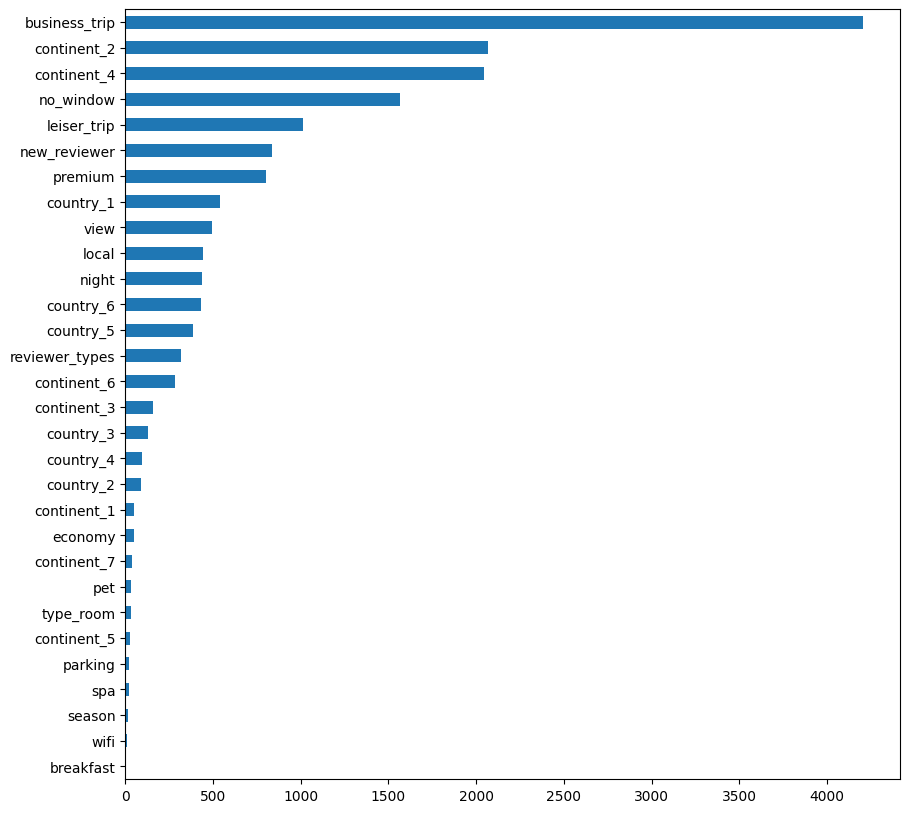

In [269]:
y_int=y.astype('int')


from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[X['type']=='train'][cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наименее показательны параметры, полученные из анализа тегов: наличие wifi, завтрак, spa, парковка

### Проверим признаки на мультиколлинеарность

Для непрерывных признаков воспользуемся корреляцией Пирсона, для категориальных -Спирмана

Text(0.5, 1.0, 'Корреляция непрепрывных признаков')

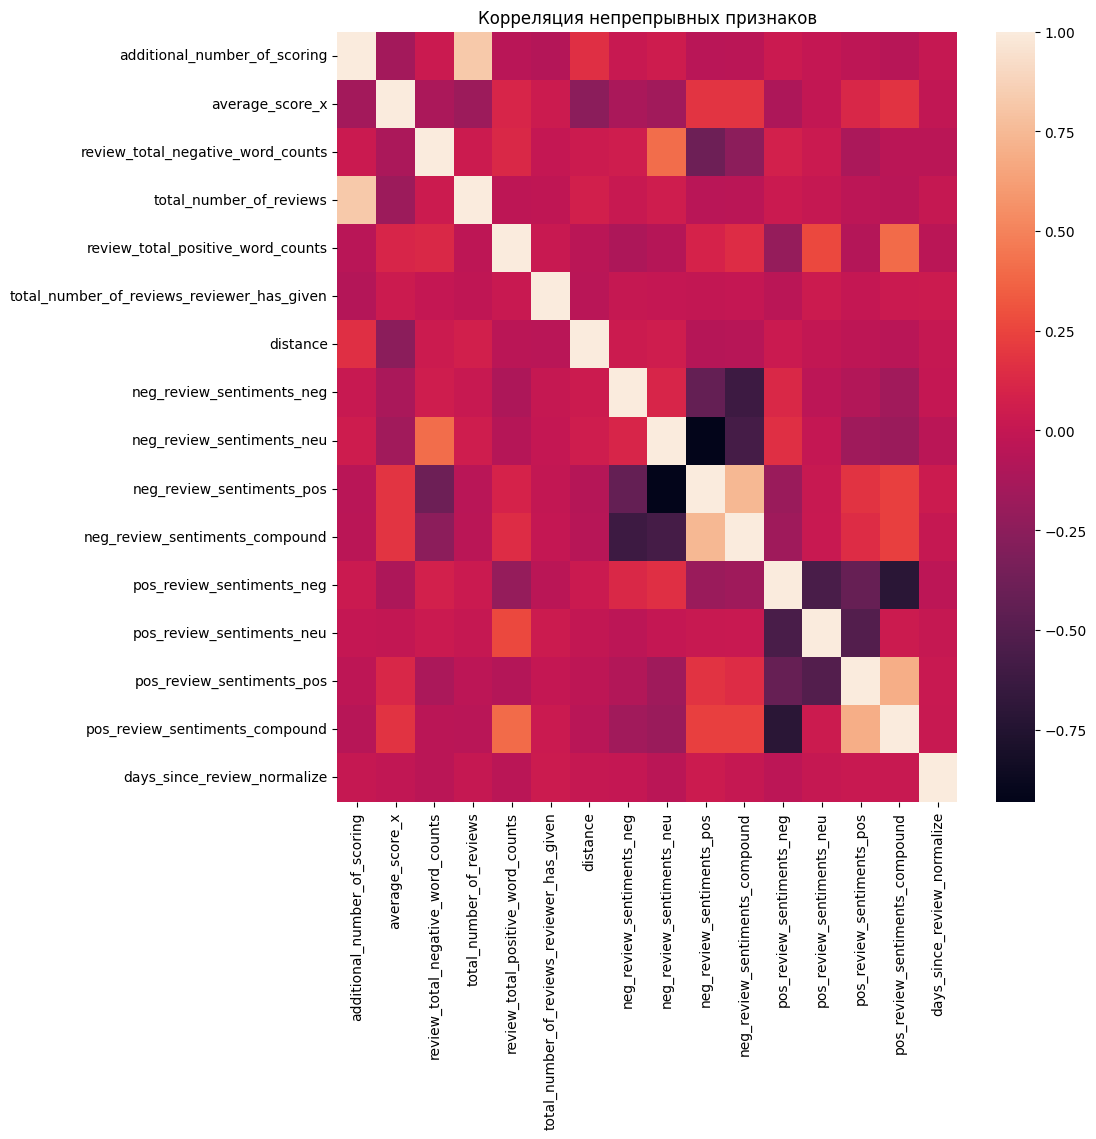

In [270]:
import seaborn as sns
sns.heatmap(X[num_cols].corr()).set_title('Корреляция непрепрывных признаков');

Text(0.5, 1.0, 'Корреляция номинативных признаков')

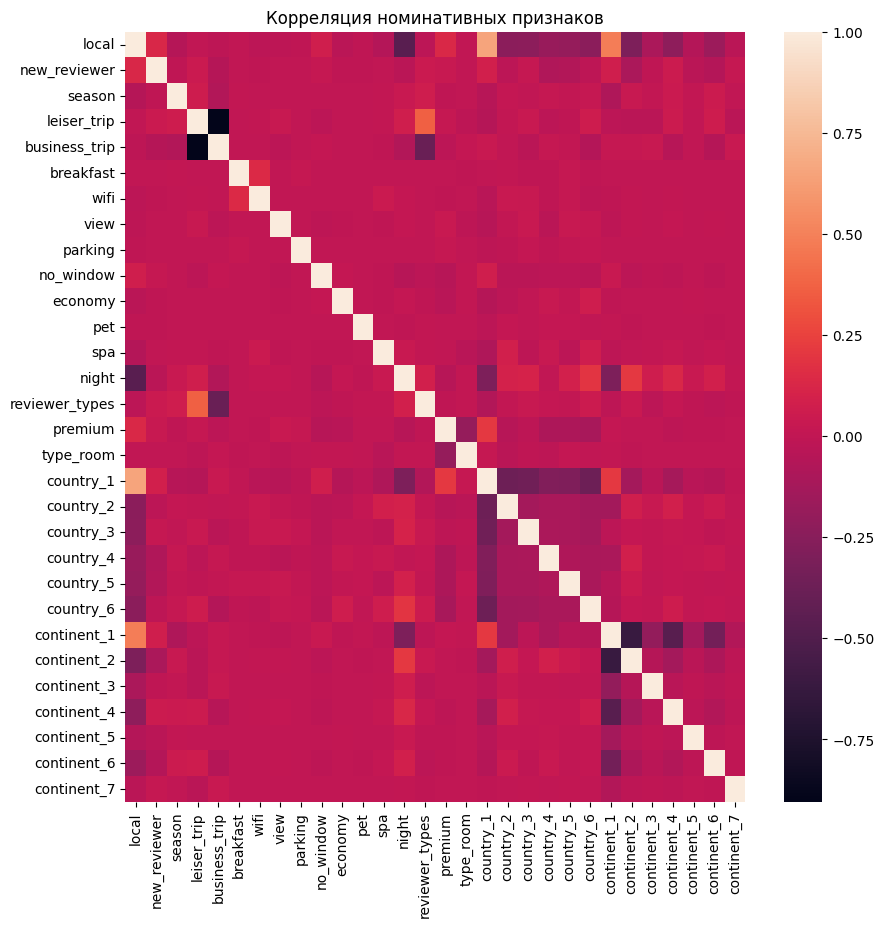

In [271]:
sns.heatmap(X[cat_cols].corr(method='spearman') ).set_title('Корреляция номинативных признаков');

In [272]:
#X=X.drop(columns=['local', 'breakfast', 'pos_review_sentiments_pos']) #попробовала удалить данные признаки, т.к. отметила по ним корреляцию с другими признаками, но результат стал хуже

In [273]:
X_all=X.copy()

In [274]:
X=X[X['type']=='train'].drop(columns=['type'])

### Приступаем к обучению модели

In [275]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [276]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [277]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=42)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


In [278]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12090651842715097


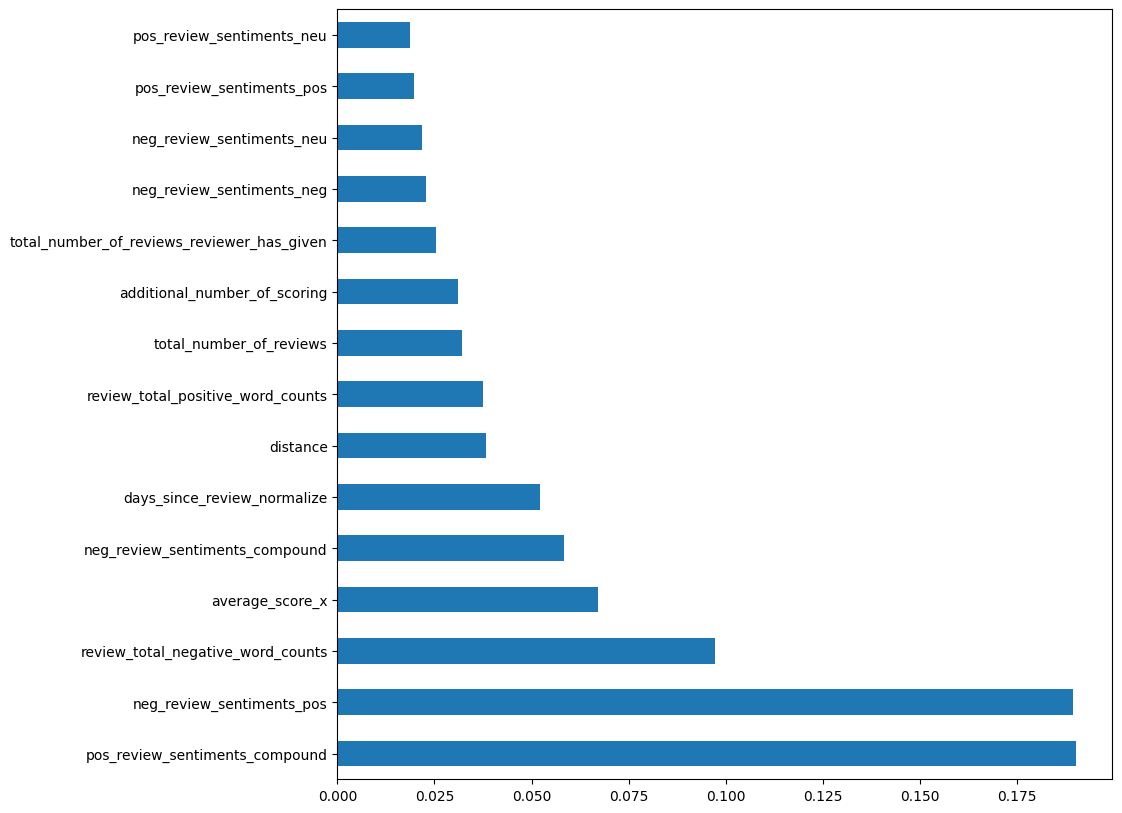

In [279]:
import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns) #выведем топ информативных признаков в нашей модели
feat_importances.nlargest(15).plot(kind='barh', title='Информативность признаков в модели');

Ранее в модели у меня был закодирован признак с наименование отеля, но т.к. информативность данного признака оказалась минимальна, то я избавилась от него

### Формируем предсказания для соревнования

In [280]:
sample_submission=pd.read_csv('data\submission.csv')

In [281]:
test_data = X_all[X_all['type']=='test'].drop(columns=['type'], axis=1)
predict_submission = regr.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


,reviewer_score,id
0,8.456,488440
1,7.633,274649
2,8.089,374688
3,9.703,404352
4,9.550,451596
5,9.043,302161
6,7.798,317079
7,7.793,13963
8,8.255,159785
9,7.206,195089
